In [1]:
import matplotlib.pyplot as plt                 # type: ignore
import pandas as pd                             # type: ignore
from gridWorldEnvironment_sto import GridWorld      # type: ignore

import numpy as np                              # type: ignore 
import seaborn as sns                           # type: ignore 
from lolviz import *                            # type: ignore

In [2]:
df_sto = df_sto = pd.read_csv("gw_stochastic.txt", 
                                       header = None, 
                                       sep = "\t",
                                       names=['current_state', 'action', 'next_state', 'reward', 'next_states', 'probabilities[L,R,U,D]'])

In [3]:
# parameters
gamma      = 1 # discounting rate
rewardSize = -1
gridSize   = 4
terminationStates = [0, 15]

In [4]:
# creating gridworld environment
gw = GridWorld( gamma = gamma,
                rewardSize=rewardSize,
                gridSize=gridSize,
                )

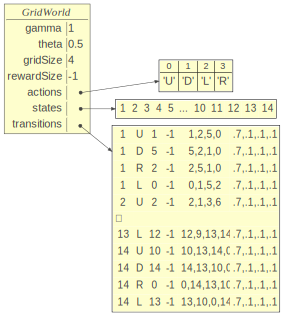

In [5]:
objviz(gw)      

#### Show environment
- Visualized environment is shown as table
- Note that terminal states (0,0) and (3,3) are added

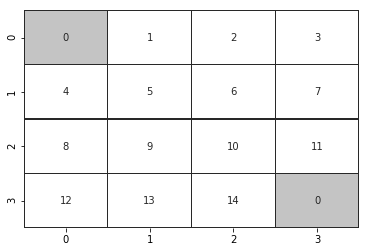

In [6]:
gw.show_environment()

In [7]:
print("Actions: ", gw.actions)
print("States: ",  gw.states)

Actions:  ('U', 'D', 'L', 'R')
States:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [22]:
print(gw.state_transition(12, "U"))

(12, -1)


#### Generate random episode
- For Monte Carlo methods, random episodes from starting state to terminal state should be generated in advance
    - Random episode below follows `equiprobable random policy` (i.e., same probabilities for each action)

In [24]:
def generate_random_episode(env):
    episode = []
    done    = False
    
    current_state = np.random.choice(env.states)
    
    episode.append((current_state, -1))
    
    while not done:
        action = np.random.choice(env.actions)
        
        next_state, reward = gw.state_transition(current_state, action)
        
        episode.append((next_state, reward))
        
        if next_state == 0:
            done = True
            
        current_state = next_state
        
    return episode

In [26]:
gw.transitions

array([[1, 'U', 1, -1, '1,2,5,0', '.7,.1,.1,.1'],
       [1, 'D', 5, -1, '5,2,1,0', '.7,.1,.1,.1'],
       [1, 'R', 2, -1, '2,5,1,0', '.7,.1,.1,.1'],
       [1, 'L', 0, -1, '0,1,5,2', '.7,.1,.1,.1'],
       [2, 'U', 2, -1, '2,1,3,6', '.7,.1,.1,.1'],
       [2, 'D', 6, -1, '6,1,2,3', '.7,.1,.1,.1'],
       [2, 'R', 3, -1, '3,6,2,1', '.7,.1,.1,.1'],
       [2, 'L', 1, -1, '1,2,3,6', '.7,.1,.1,.1'],
       [3, 'U', 3, -1, '3,2,7', '.8,.1,.1'],
       [3, 'D', 7, -1, '7,2,3', '.8,.1,.1'],
       [3, 'R', 3, -1, '3,2,7', '.8,.1,.1'],
       [3, 'L', 2, -1, '2,3,7', '.8,.1,.1'],
       [4, 'U', 0, -1, '0,4,5,8', '.7,.1,.1,.1'],
       [4, 'D', 8, -1, '8,5,0,4', '.7,.1,.1,.1'],
       [4, 'R', 5, -1, '5,0,4,8', '.7,.1,.1,.1'],
       [4, 'L', 4, -1, '4,0,5,8', '.7,.1,.1,.1'],
       [5, 'U', 1, -1, '1,4,6,9', '.7,.1,.1,.1'],
       [5, 'D', 9, -1, '9,4,1,6', '.7,.1,.1,.1'],
       [5, 'R', 6, -1, '6,1,4,9', '.7,.1,.1,.1'],
       [5, 'L', 4, -1, '4,9,1,6', '.7,.1,.1,.1'],
       [6, 'U', 2, -

Initialize value functions of states to 0

In [27]:
def value_array(env):
    return np.zeros(len(env.states)+2)

In [28]:
nbr_cycles_of_MC_run    = 8
nbr_episodes_each_cycle = 100
number_plots_per_row    = 4

#### First-visit 
- Estimates $v_\pi(s)$ as the average of the returns following first visit to $s$
    - Most widely studied (from 1940s)

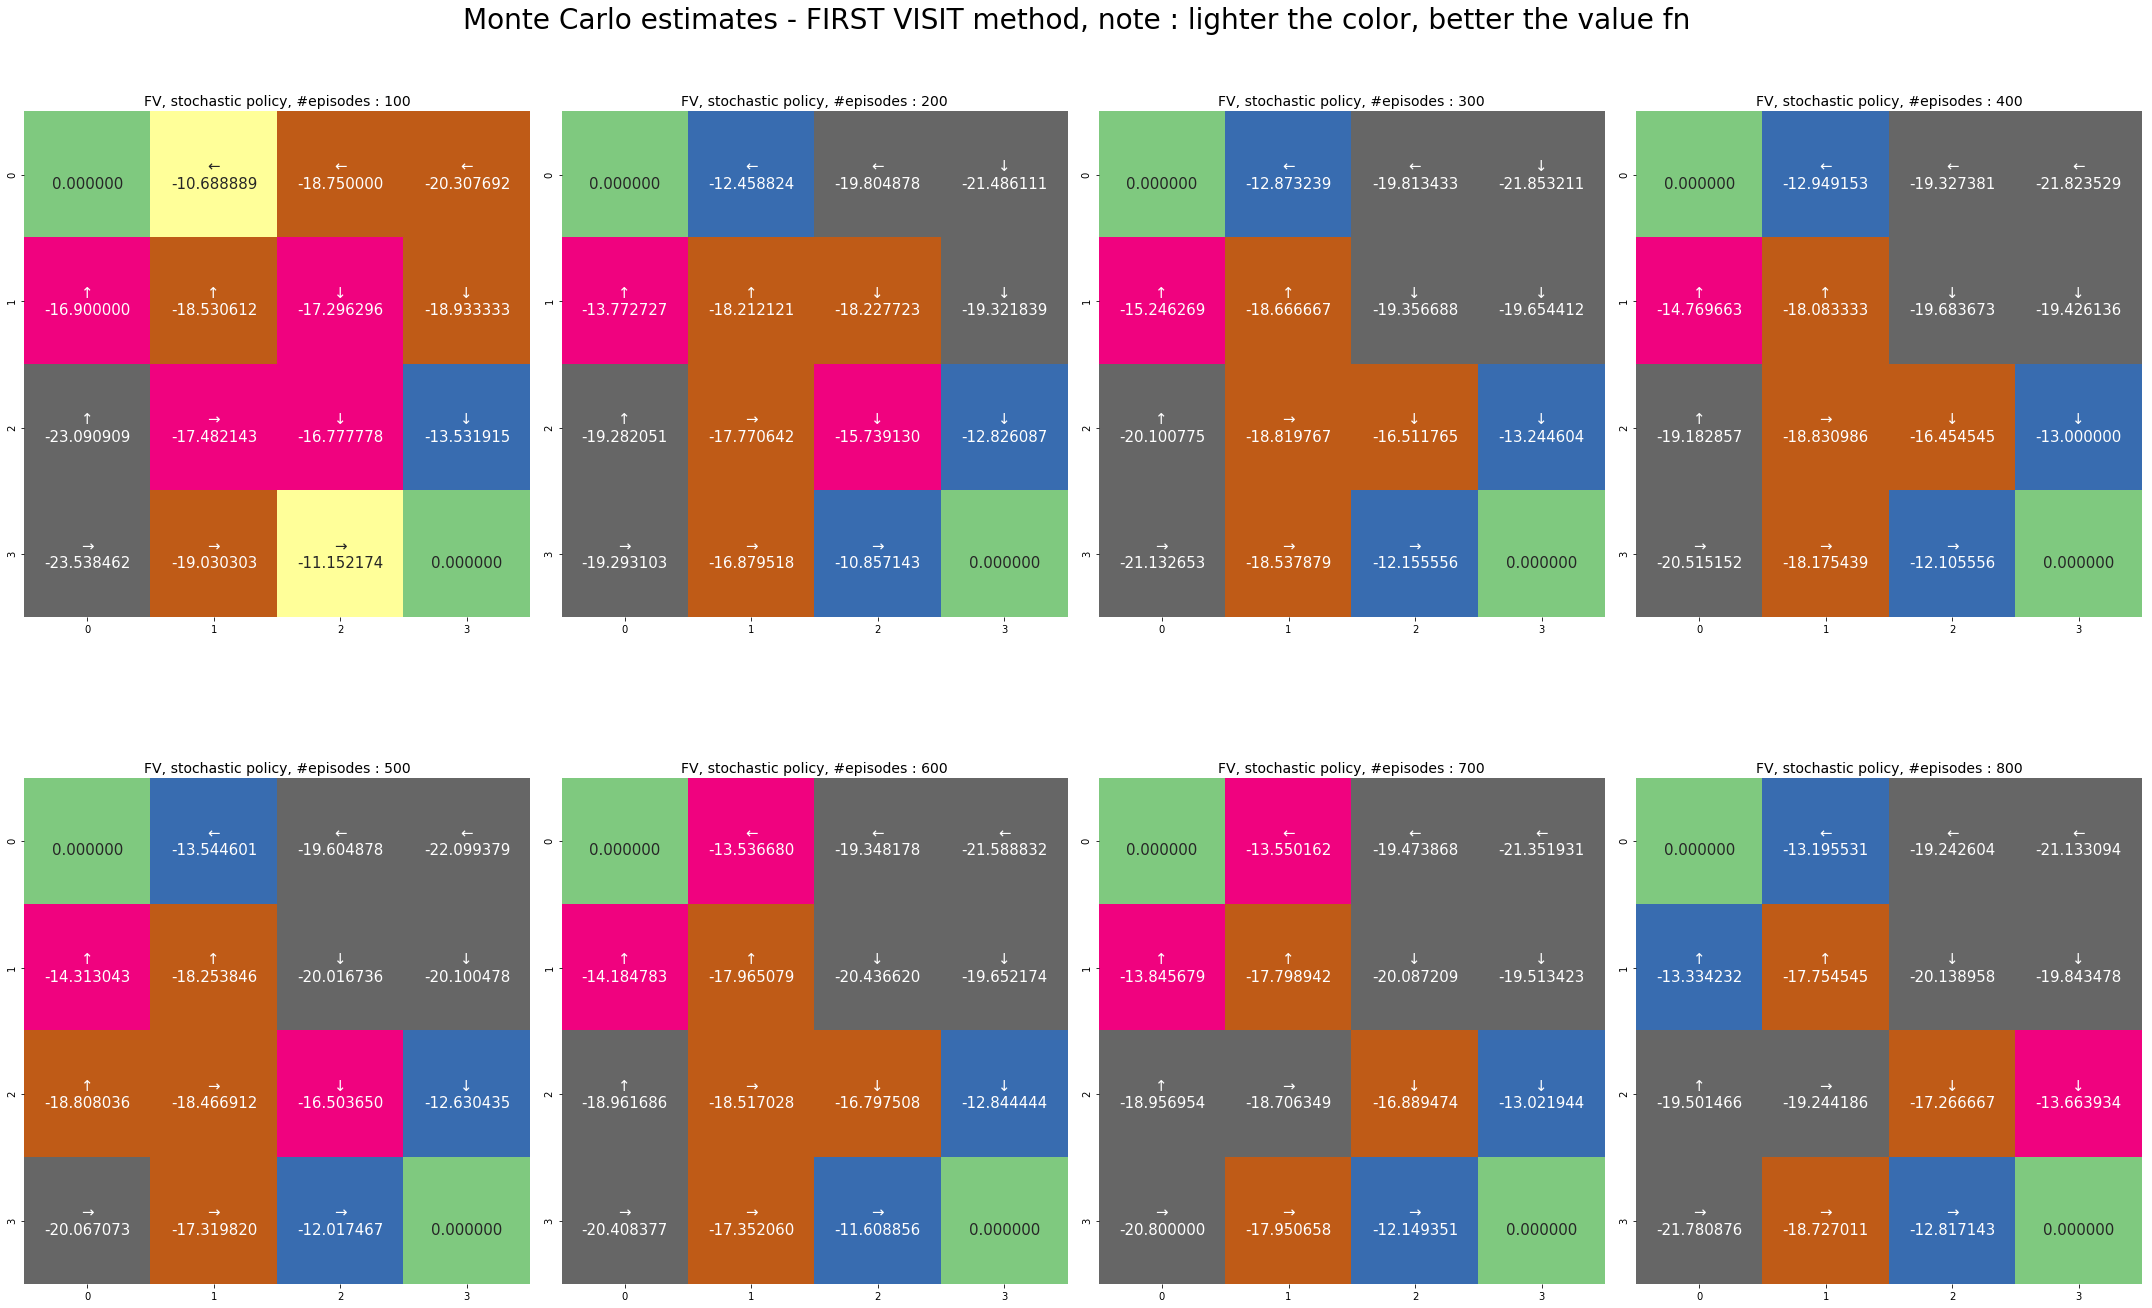

In [29]:
FV_V=dict()
FV_policy = dict()
FV_policy_dirs_chars = dict()

fig, ax = plt.subplots(nrows=nbr_cycles_of_MC_run//number_plots_per_row, ncols=number_plots_per_row, figsize=(30, 20))

fig.suptitle('Monte Carlo estimates - FIRST VISIT method, note : lighter the color, better the value fn\n\n', fontsize=28)

values  = value_array(gw)
returns = dict()

for state in gw.states:
    returns[state] = list()

for cycle in range(nbr_cycles_of_MC_run):

    for i in range(nbr_episodes_each_cycle):
        episode = generate_random_episode(gw)
        
        already_visited = set({0})             # also exclude terminal state (0)
        
        for s, r in episode:
            if s not in already_visited:
                
                already_visited.add(s)
                
                idx = episode.index((s, r))
                
                G = 0
                j = 1
                
                while j + idx < len(episode):
                    G = gw.gamma * (G + episode[j + idx][1])
                    j += 1
                    
                returns[s].append(G)
                values[s] = np.mean(returns[s])

    V = np.array(values).reshape(4,4)
    policy, all_dirs_chars = gw.get_policy(V)

    FV_V['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = V
    FV_policy['FV-'+str((cycle+1)*nbr_episodes_each_cycle)]= policy
    FV_policy_dirs_chars['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = all_dirs_chars

    sns.heatmap(V, 
            annot=policy, 
            fmt='', 
            cbar=False,
            square=True, 
            cmap='Accent_r',
            annot_kws={"size":15},
            ax=ax[cycle//number_plots_per_row, cycle%number_plots_per_row]
            )
    ax[cycle//number_plots_per_row, cycle%number_plots_per_row].set_title('FV, stochastic policy, #episodes : {}'.format(str((cycle+1)*nbr_episodes_each_cycle)), fontsize=14)

plt.tight_layout()